In [60]:
from seligator.main import Seligator
from seligator.prediction.tests import run_tests

# sel = Seligator.load_model("saved_model_nometadata")
sel = Seligator.load_model("models/form-century")
sel.model.cuda()
reader = sel.get_reader()
sel.model

sel.vocabulary

/home/thibault/dev/est-lascivuum-non-est/env/lib/python3.8/site-packages/allennlp/data/token_indexers/token_characters_indexer.py:55: UserWarning: You are using the default value (0) of `min_padding_length`, which can cause some subtle bugs (more info see https://github.com/allenai/allennlp/issues/1954). Strongly recommend to set a value, usually the maximum size of the convolutional layer size when using CnnEncoder.
  warnings.warn(


Vocabulary with namespaces:  lemma, Size: 155390 || [msd], Size: 52 || lemma_char, Size: 75 || labels, Size: 2 || WrittenType_ns_labels, Size: 3 || Century_ns_labels, Size: 13 || Non Padded Namespaces: {'*tags', '*labels'}

Evaluating


0it [00:00, ?it/s]

/home/thibault/dev/est-lascivuum-non-est/seligator/models/classifier.py:65: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(logits)


Evaluating: Predicting


/home/thibault/dev/est-lascivuum-non-est/seligator/prediction/tests.py:57: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  disp.figure_.show()


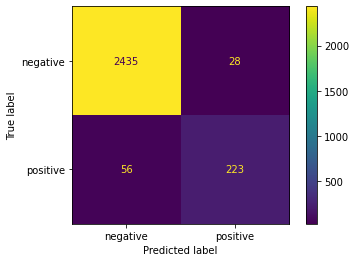

In [3]:
data, img = run_tests(
    "dataset/main/test.txt",
    dataset_reader=reader,
    model=sel.model
)

In [4]:
from seligator.prediction.html import predictions_to_html

In [ ]:


# Do Ausone
output = sel.predict_on_xml(
    "/home/thibault/dev/latin-lemmatized-texts/lemmatized/xml/urn:cts:latinLit:stoa0045.stoa003.perseus-lat2.xml",
     metadata={
        "Century": "4",
        #"CitationTypes": "line",
        #"Textgroup": "urn:cts:latinLit:stoa0045",
        "WrittenType": "versified"
})
with open("ausone-as-ausone.html", "w") as f:
    f.write(predictions_to_html(output, show_class=False))

# Same with Virgile
output = sel.predict_on_xml(
    "/home/thibault/dev/latin-lemmatized-texts/lemmatized/xml/urn:cts:latinLit:stoa0045.stoa003.perseus-lat2.xml",
     metadata={
        "Century": "-1",
        #"CitationTypes": "poem,line",
        #"Textgroup": "urn:cts:latinLit:phi0690",
        "WrittenType": "versified"
})
with open("ausone-as-virgile.html", "w") as f:
    f.write(predictions_to_html(output, show_class=False))
    
# Virgine Aeneid
output = sel.predict_on_xml(
    "/home/thibault/dev/latin-lemmatized-texts/lemmatized/xml/urn:cts:latinLit:phi0690.phi003.perseus-lat2.xml",
     metadata={
        "Century": "-1",
        "CitationTypes": "poem,line",
        #"Textgroup": "urn:cts:latinLit:phi0690",
        "WrittenType": "versified"
})
with open("virgile-as-virgile.html", "w") as f:
    f.write(predictions_to_html(output, show_class=False))
    

In [59]:
MARTIAL = {
        "Century": "1",
        "CitationTypes": "book,poem,line",
        "Textgroup": "urn:cts:latinLit:phi1294",
        "WrittenType": "versified"
}
CICERON = {
        "Century": "-1",
        "CitationTypes": "book,section",
        "Textgroup": "urn:cts:latinLit:phi0474",
        "WrittenType": "prose"
}


def fix_start_end(list_of_sent):
    x = [
        
        {
            "start": f"Unk{i}",
            "end": f"Unk{i}.end",
            **sent
        }
        for i, sent in enumerate(list_of_sent)
    ]
    return x
    
    
def taux_positif(sents):
    return "{:.2f}%".format(100*sum([int(sent["prediction"] == "positive") for sent in sents])/len(sents))


def run_on(model_path: str = "models/all-metadata", exclude = None, write=False):
    m = Seligator.load_model(model_path)
    m.model.cuda()
    m.model.eval()
    reader = sel.get_reader()
    print(
        m.vocabulary
    )
    
    exclude = exclude or []
    
    martial = {key: val for key, val in MARTIAL.items() if key not in exclude}
    ciceron = {key: val for key, val in CICERON.items() if key not in exclude}
    
    # Martial as Martial
    mar_mar = m.predict_on_xml(
        "/home/thibault/dev/latin-lemmatized-texts/lemmatized/xml/urn:cts:latinLit:phi1294.phi002.perseus-lat2.xml",
         metadata=martial)
    if write:
        with open("martial-as-martial.html", "w") as f:
            f.write(predictions_to_html(mar_mar, show_class=False))

    # Martial as Cicero
    mar_cic = m.predict_on_xml(
        "/home/thibault/dev/latin-lemmatized-texts/lemmatized/xml/urn:cts:latinLit:phi1294.phi002.perseus-lat2.xml",
         metadata=ciceron)
    if write:
        with open("martial-as-cicero.html", "w") as f:
            f.write(predictions_to_html(mar_cic, show_class=True))

    # Cicero as Cicero
    cic_cic = m.predict_on_xml(
        "/home/thibault/dev/latin-lemmatized-texts/lemmatized/xml/urn:cts:latinLit:phi0474.phi048.perseus-lat1.xml",
         metadata=ciceron)
    if write:
        with open("cicero-as-cicero.html", "w") as f:
            f.write(predictions_to_html(fix_start_end(cic_cic), show_class=True))

    # Cicero as Martial
    cic_mar = m.predict_on_xml(
        "/home/thibault/dev/latin-lemmatized-texts/lemmatized/xml/urn:cts:latinLit:phi0474.phi048.perseus-lat1.xml",
         metadata=martial)
    if write:
        with open("cicero-as-martial.html", "w") as f:
            f.write(predictions_to_html(fix_start_end(cic_mar), show_class=True))
            
    return [
    {
        "Texte": "De Finibus, Cicéron",
        "Model": model_path,
        "En tant que Cicéron": taux_positif(cic_cic),
        "En tant que Martial": taux_positif(cic_mar)
    },
    {
        "Texte": "Epigrammata, Martial",
        "Model": model_path,
        "En tant que Cicéron": taux_positif(mar_cic),
        "En tant que Martial": taux_positif(mar_mar)
    }
]

In [52]:
from pandas import DataFrame


# ['Century', 'Textgroup', 'WrittenType', 'CitationTypes']
all_metadata = [
    *run_on(), # Normal
    *run_on("models/form-century-citation", exclude=["Textgroup"]), 
    *run_on("models/form-century", exclude=["Textgroup", "CitationTypes"]) , 
    *run_on("models/none", exclude=['Century', 'Textgroup', 'WrittenType', 'CitationTypes']) 
]

['Century', 'Textgroup', 'WrittenType', 'CitationTypes']


['Century', 'Textgroup', 'WrittenType', 'CitationTypes']


['Century', 'Textgroup', 'WrittenType', 'CitationTypes']


KeyboardInterrupt: 

In [50]:
print(DataFrame(all_metadata).to_latex(index=False))

\begin{tabular}{llll}
\toprule
               Texte &                        Model & En tant que Cicéron & En tant que Martial \\
\midrule
 De Finibus, Cicéron &          models/all-metadata &               4.25\% &              72.60\% \\
Epigrammata, Martial &          models/all-metadata &               7.89\% &              82.05\% \\
 De Finibus, Cicéron & models/form-century-citation &               4.69\% &              47.54\% \\
Epigrammata, Martial & models/form-century-citation &               7.33\% &              59.76\% \\
 De Finibus, Cicéron &          models/form-century &               0.91\% &              36.03\% \\
Epigrammata, Martial &          models/form-century &               6.41\% &              48.10\% \\
 De Finibus, Cicéron &                  models/none &               2.91\% &               2.91\% \\
Epigrammata, Martial &                  models/none &              15.29\% &              15.29\% \\
\bottomrule
\end{tabular}

